In [1]:
from matplotlib import pyplot as plt
import platform, os, sys
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from ipywidgets import interact, interact_manual
from scipy.optimize import minimize, fmin_cg, approx_fprime
from numpy.linalg import norm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import interp2d, SmoothBivariateSpline, RectBivariateSpline

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Level 2: calculating electron positions using `scipy.minimize` on a FEM obtained potential

In [3]:
save = False
data_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Potentials"


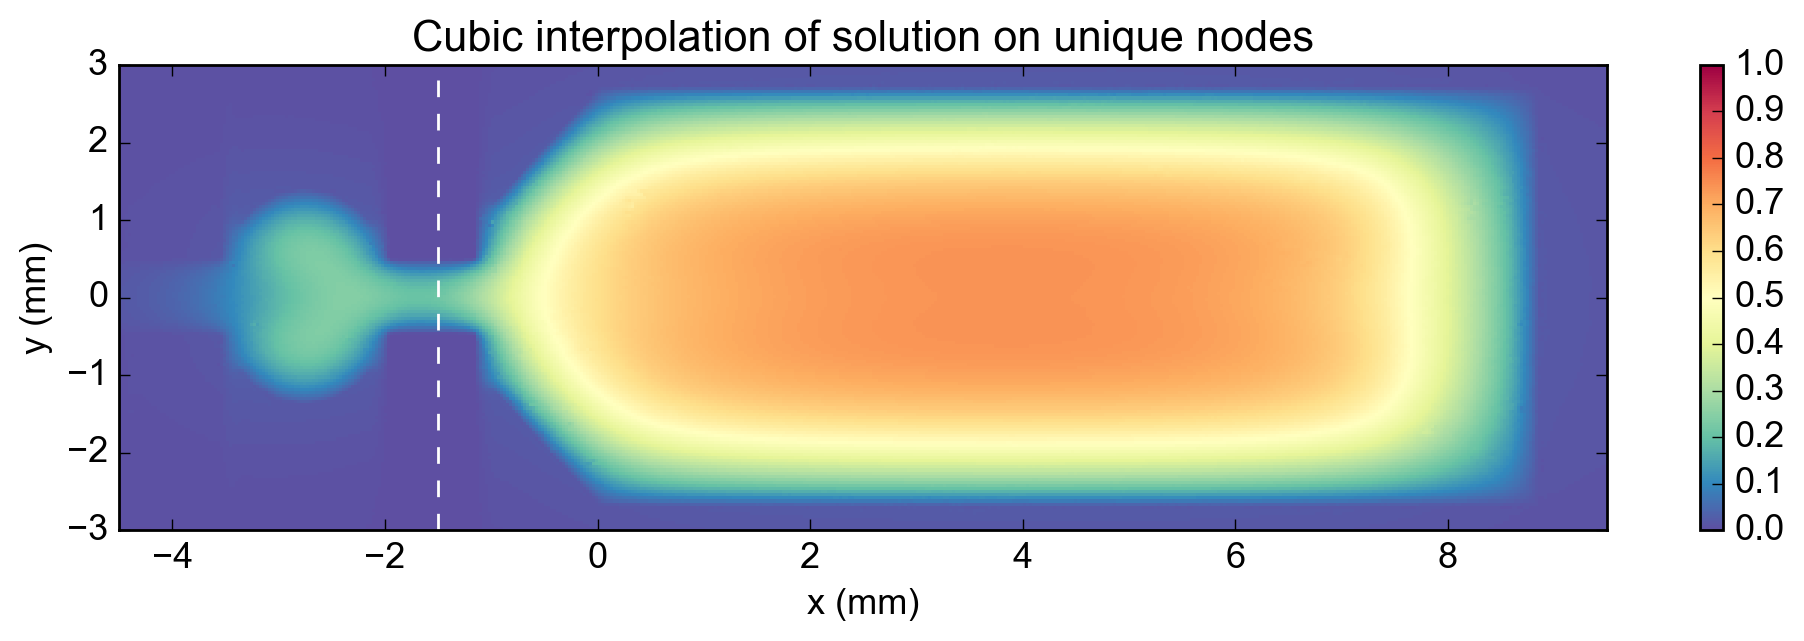

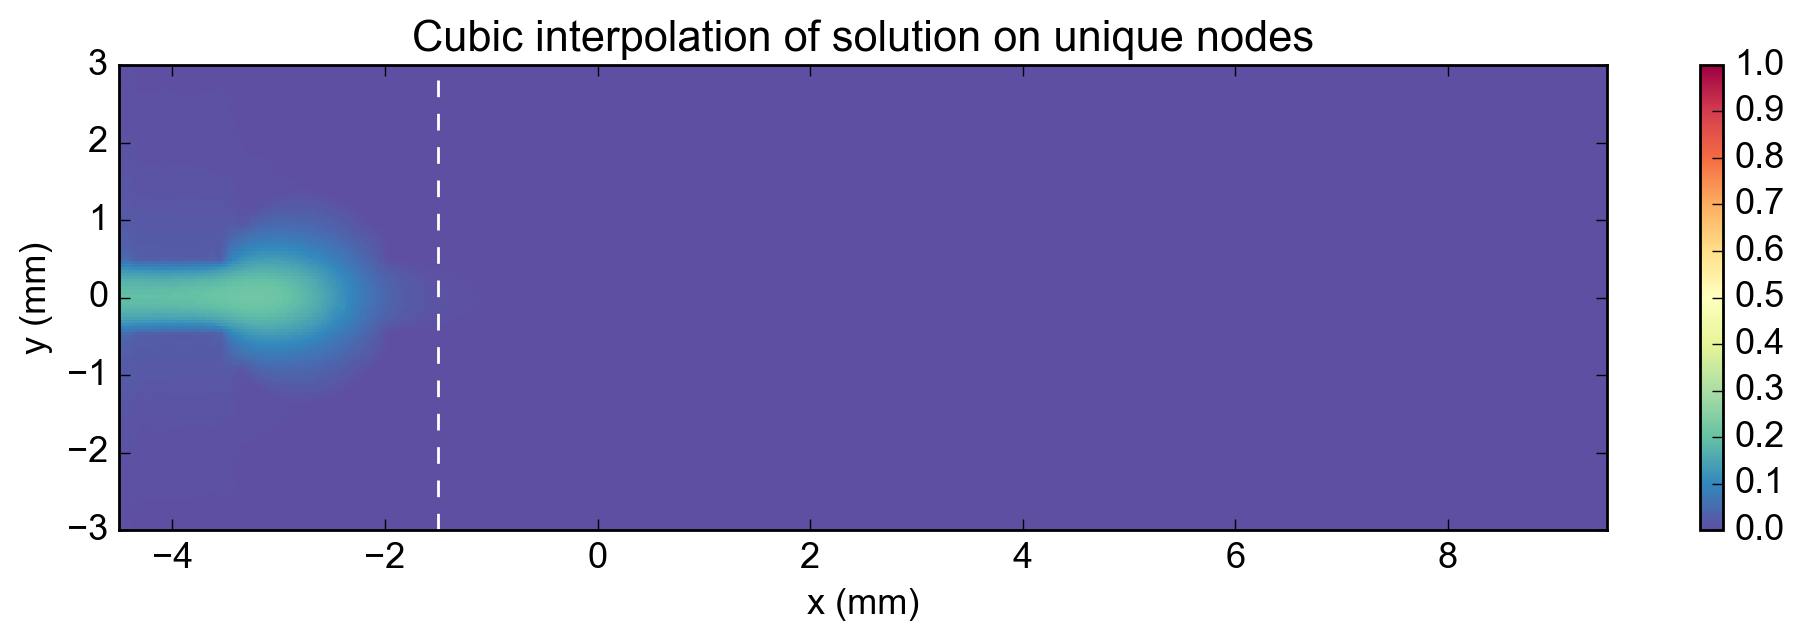

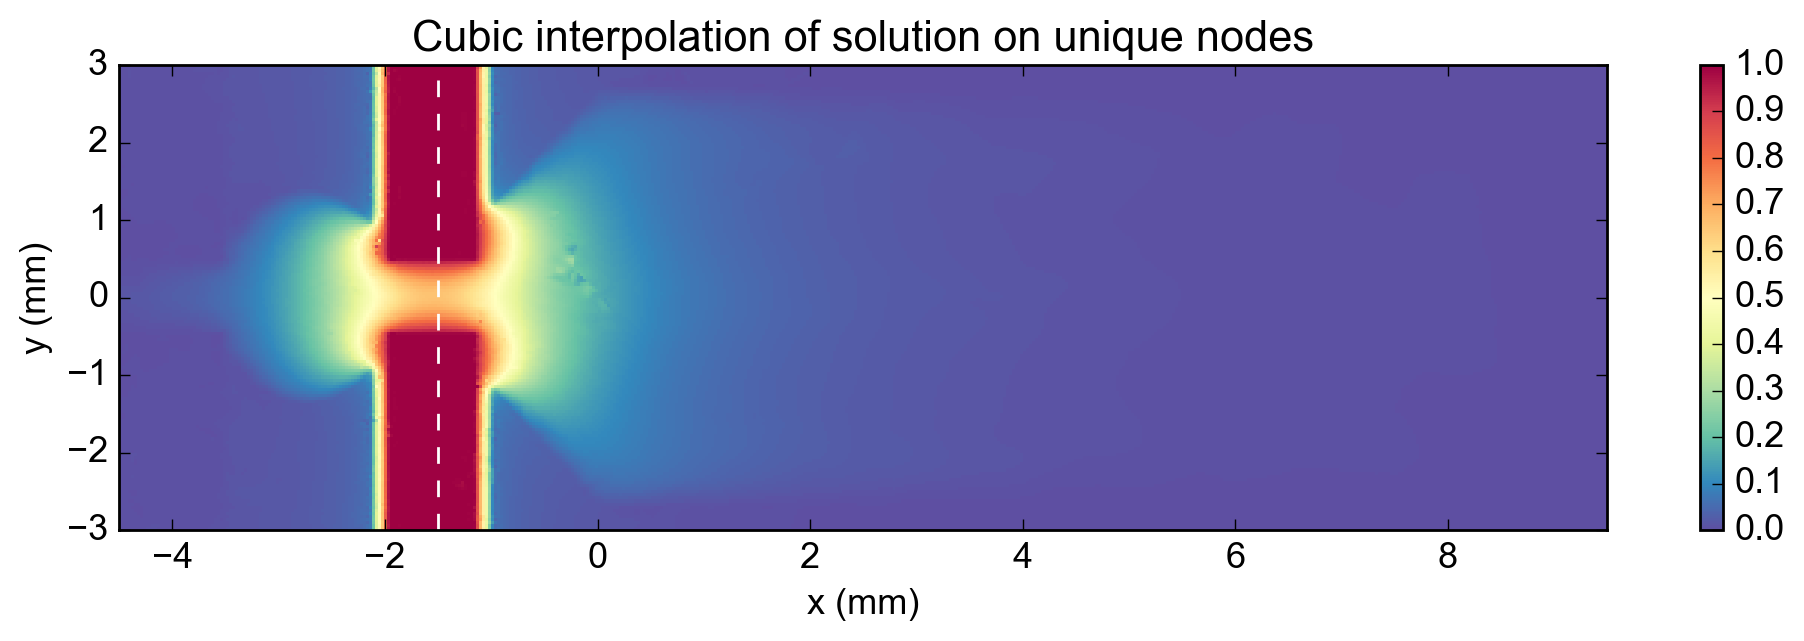

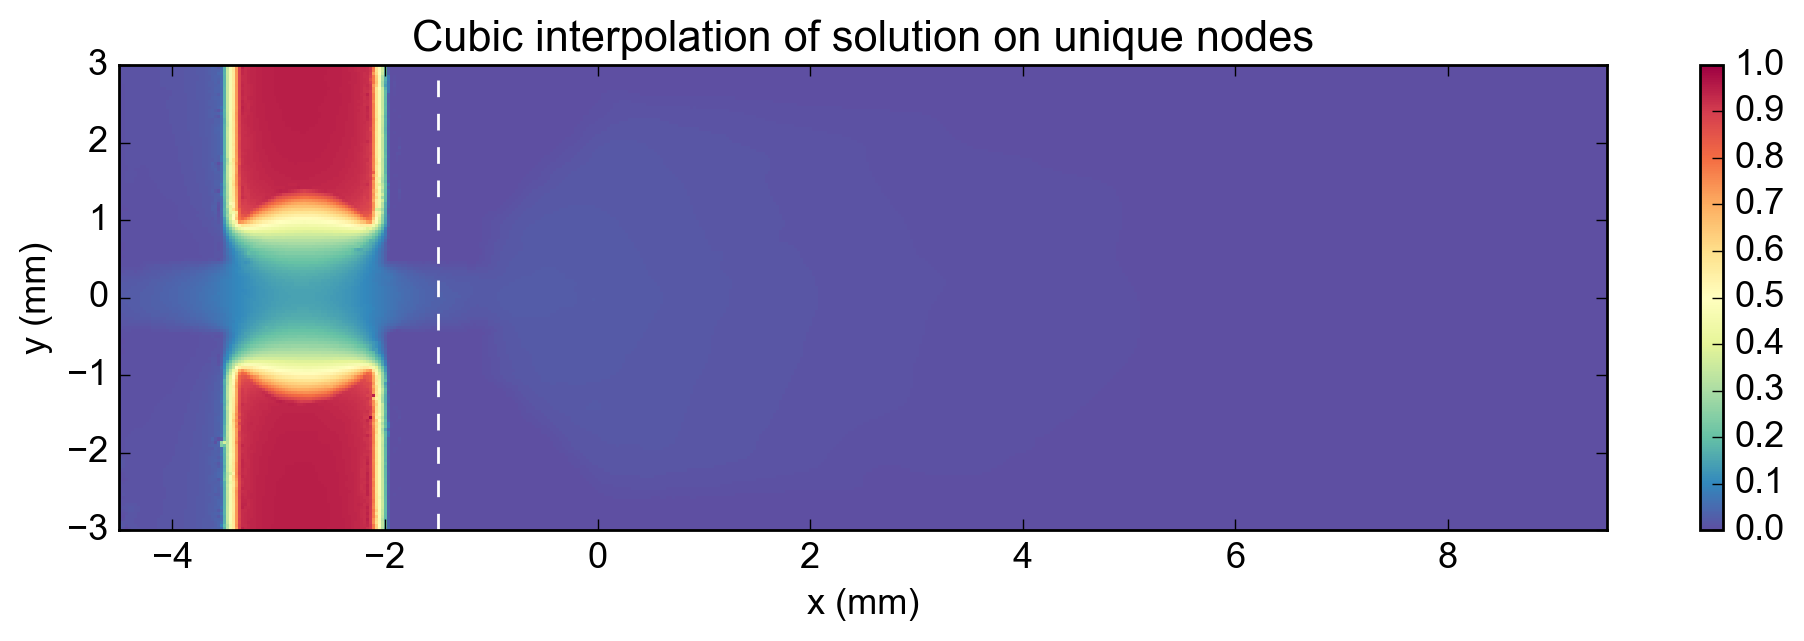

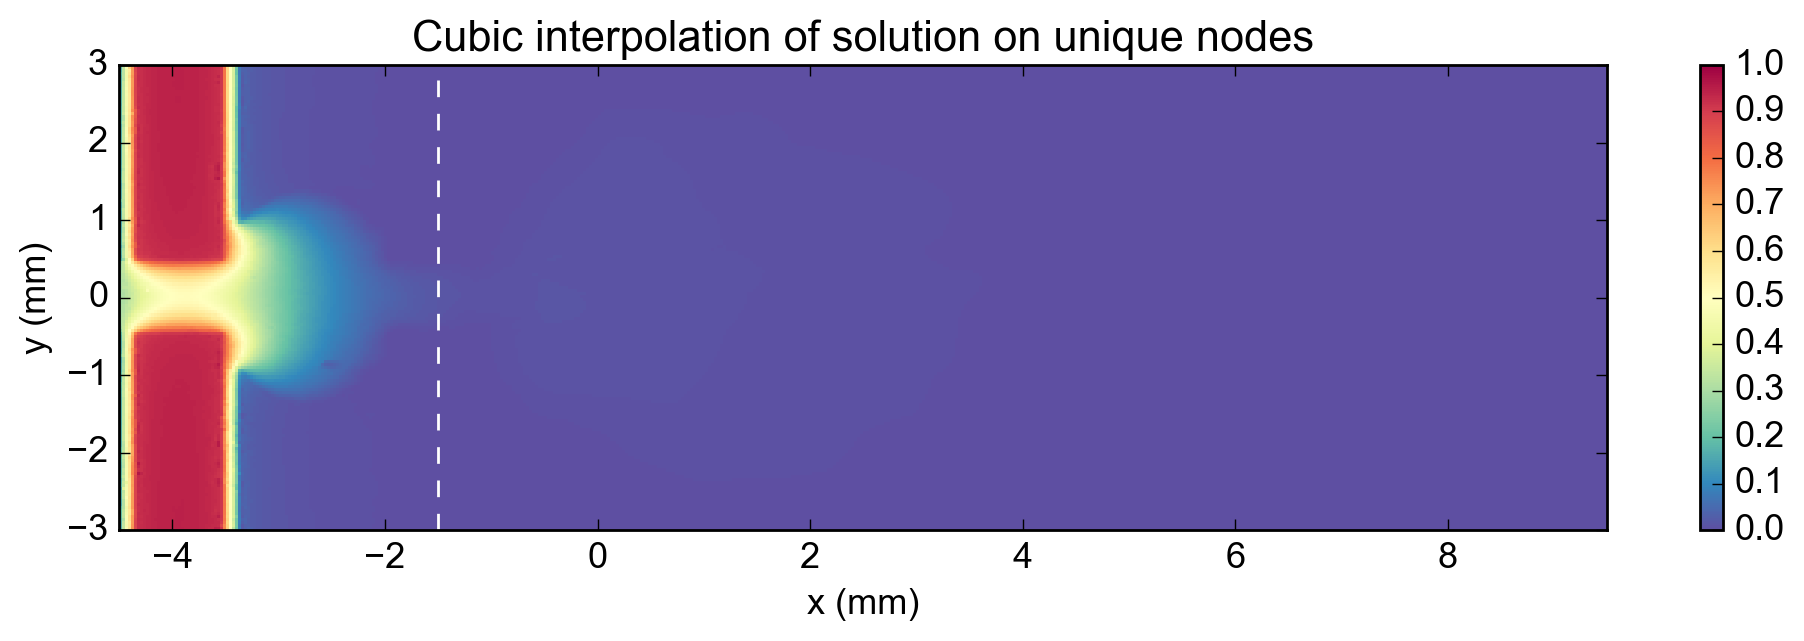

In [4]:
# Evaluate all files in the range
xeval=np.linspace(-4.5, 9.5, 501)
yeval = np.linspace(-3.0, 3.0, 151)

datafiles = [os.path.join(data_path, "Resonator.dsp"),
             os.path.join(data_path, "Trap.dsp"),
             os.path.join(data_path, "ResonatorGuard.dsp"),
             os.path.join(data_path, "CenterGuard.dsp"), 
             os.path.join(data_path, "TrapGuard.dsp")]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(12.,3.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter
    #interpolate_slow.plot_mesh(os.path.join(datafile))
    xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=(0, 1.0), 
                                                         plot_axes='xy', cmap=plt.cm.Spectral_r, plot_mesh=False)
    output.append({'name' : name, 'V' : np.array(Uinterp.T, dtype=np.float64),
                               'x' : np.array(xinterp.T, dtype=np.float64), 'y' : np.array(yinterp.T, dtype=np.float64)})
    
    plt.vlines(-1.5, np.min(yeval), np.max(yeval), linestyles="--", color="white")

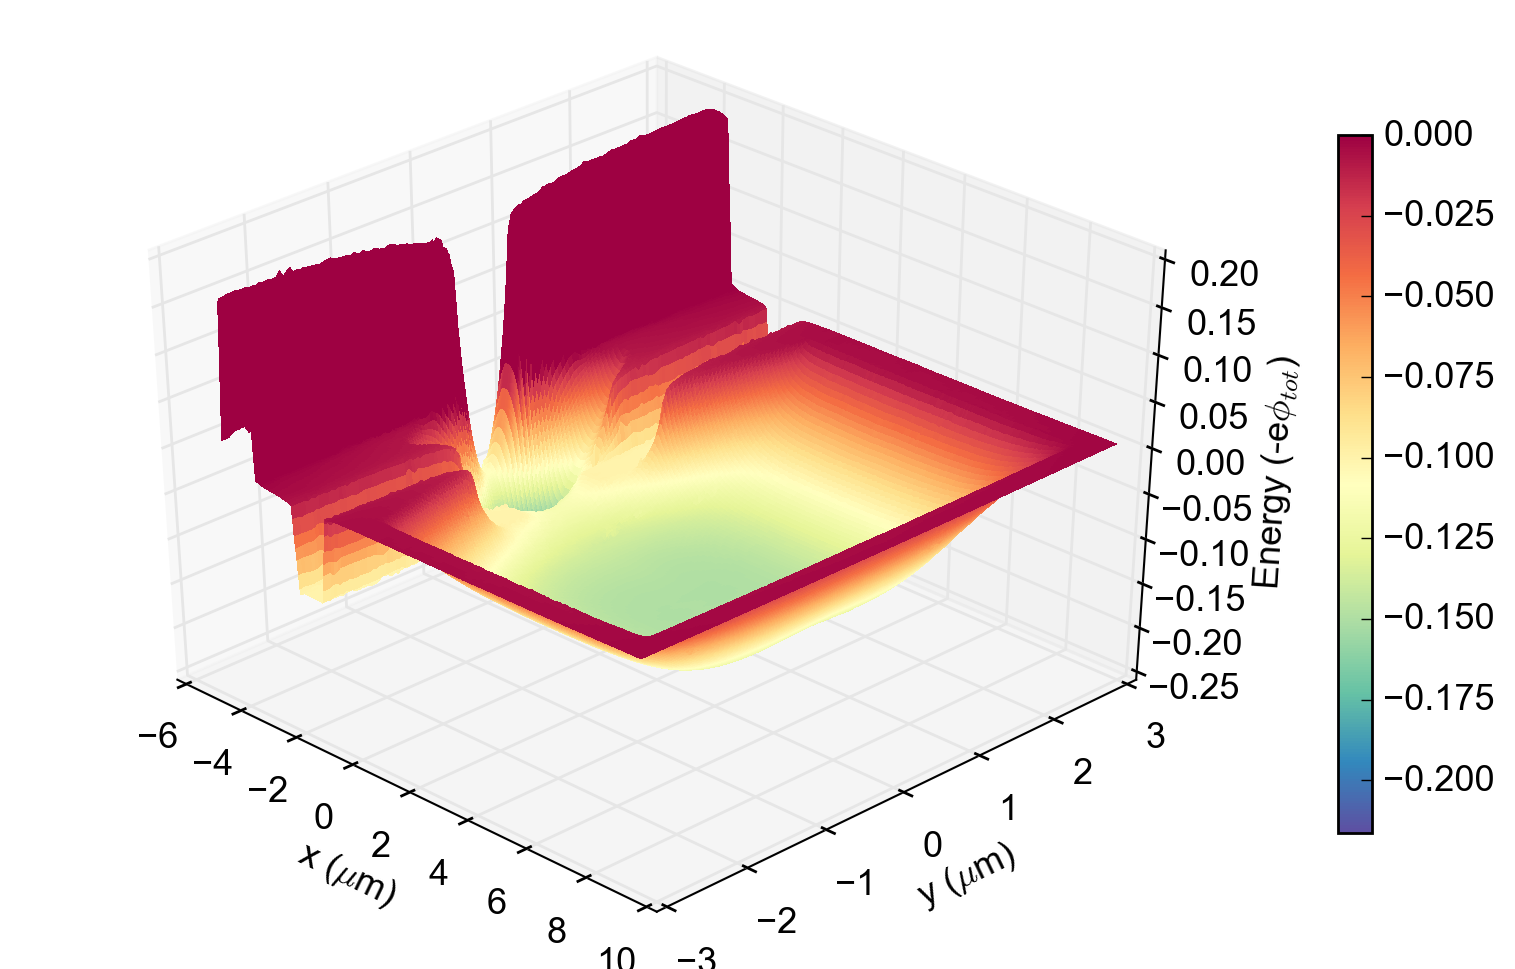

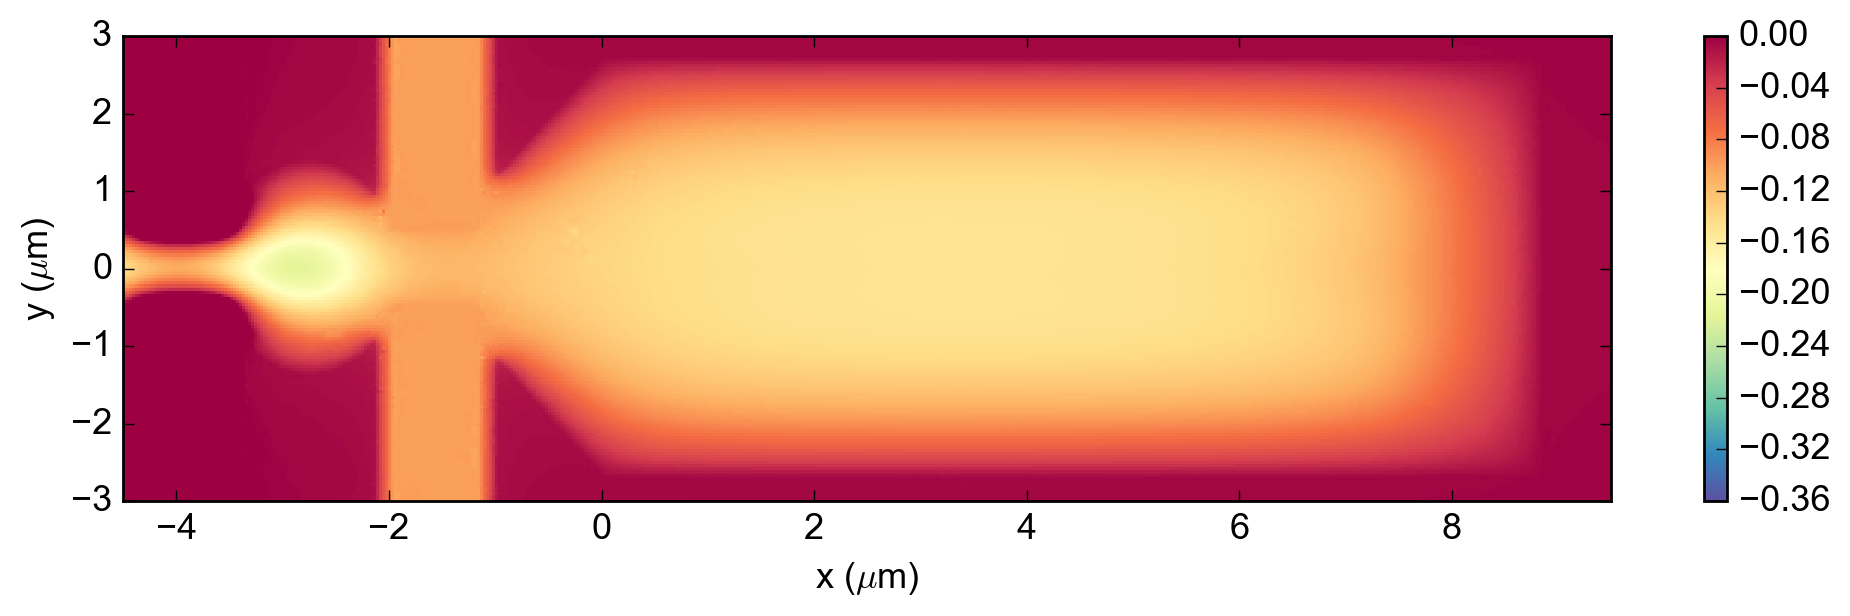

In [5]:
t = trap_analysis.TrapSolver()
c = trap_analysis.get_constants()

Vres = 0.20
Vtrap = 1.00
Vrg = 0.10
Vcg = 0.0
Vtg = -0.20

xeval, yeval, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
coefficients = np.array([Vres, Vtrap, Vrg, Vcg, Vtg])
combined_potential = t.get_combined_potential(cropped_potentials, coefficients)

Xm, Ym = np.meshgrid(xeval, yeval)

for view_angle in [-45]:
    fig = plt.figure(figsize=(10.,6.))
    common.configure_axes(13)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(Xm, Ym, -combined_potential, rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                           linewidth=0, antialiased=False, vmax=0.0)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_zlabel("Energy (-e$\phi_{tot}$)")
    ax.view_init(elev=35., azim=view_angle)
    fig.colorbar(surf, shrink=0.75, aspect=20)  
    
fig = plt.figure(figsize=(12.,3.))
common.configure_axes(13)
plt.pcolormesh(Xm, Ym, -combined_potential, cmap=plt.cm.Spectral_r, vmax=0.0, vmin=-0.36)
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")
plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
plt.colorbar()

In [6]:
Interpolator = RectBivariateSpline(xeval*1E-6, yeval*1E-6, -combined_potential.T, kx=3, ky=3, s=0.005)

def Vext_meshgrid(xi, yi):
    return Interpolator.ev(xi, yi)

def grady_Vext(xi, yi):
    return Interpolator.ev(xi, yi, dx=0, dy=1)

def gradx_Vext(xi, yi):
    return Interpolator.ev(xi, yi, dx=1, dy=0)

Verify that the above interpolation function represents the FEM data: 

In [7]:
Vext_meshgrid(np.array([0.0, 1.0E-6, 2.0E-6]), np.array([0.0, -1E-6, 2E-6]))

array([-0.13674075, -0.1390989 , -0.09235954])

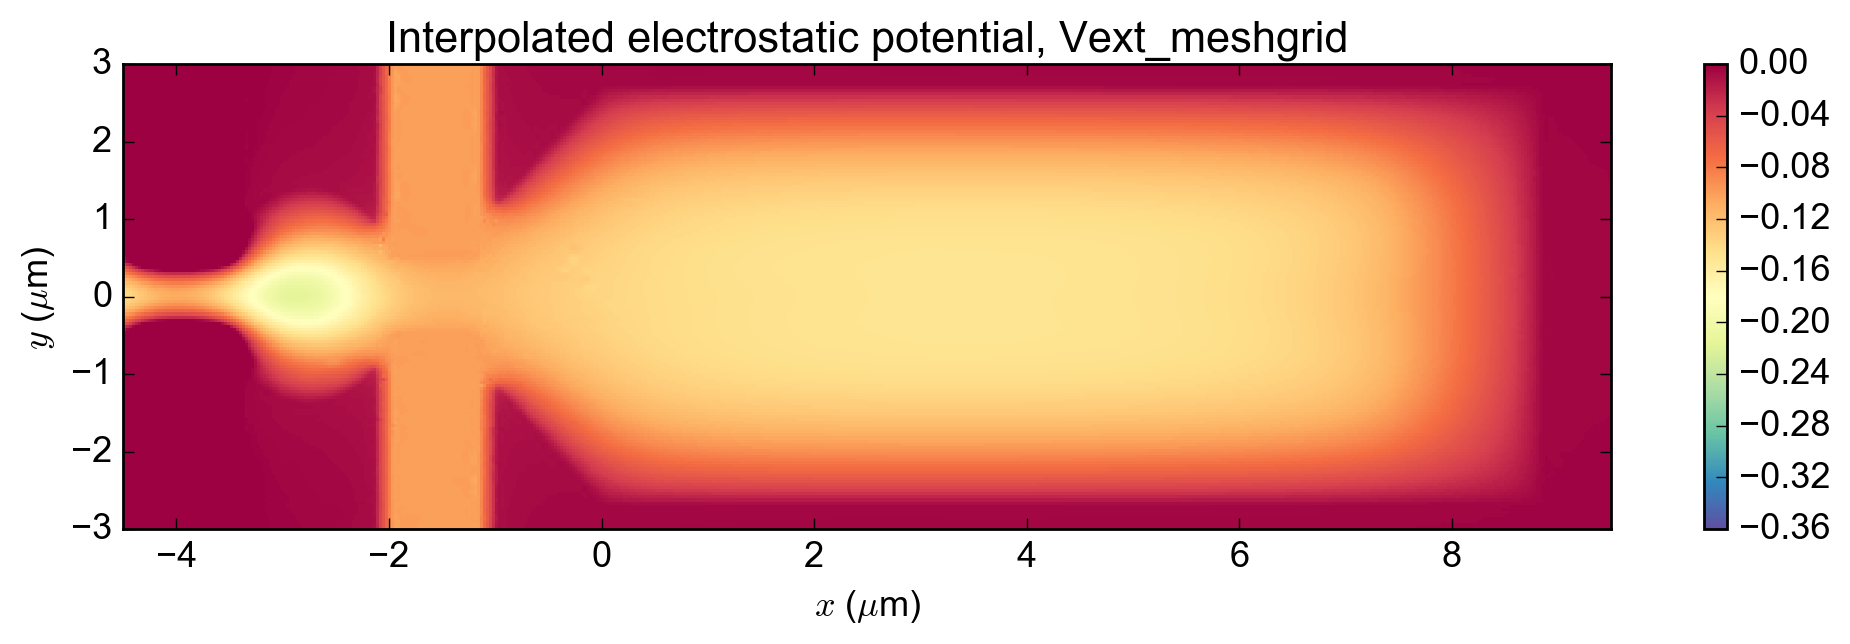

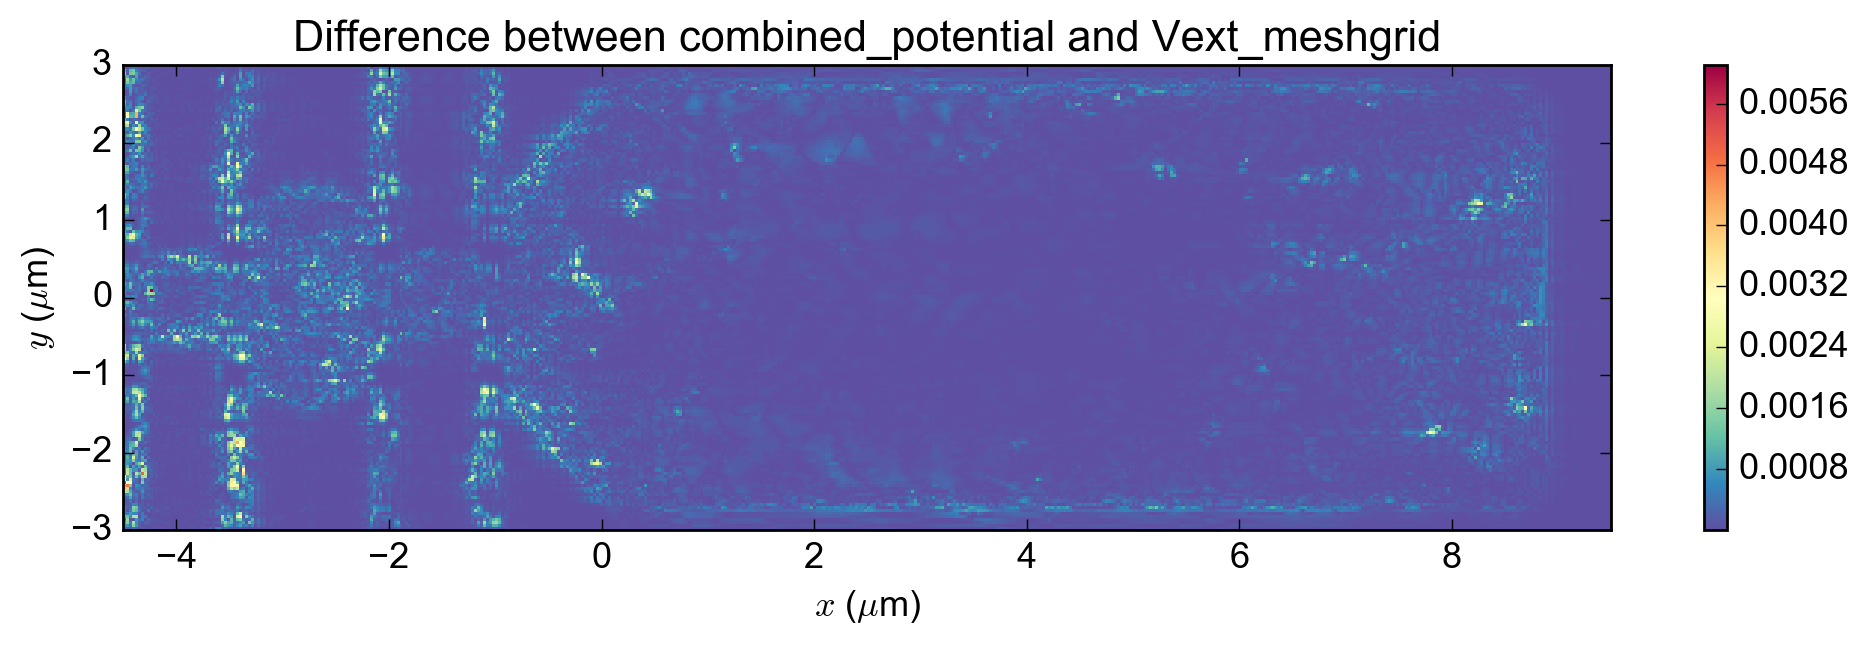

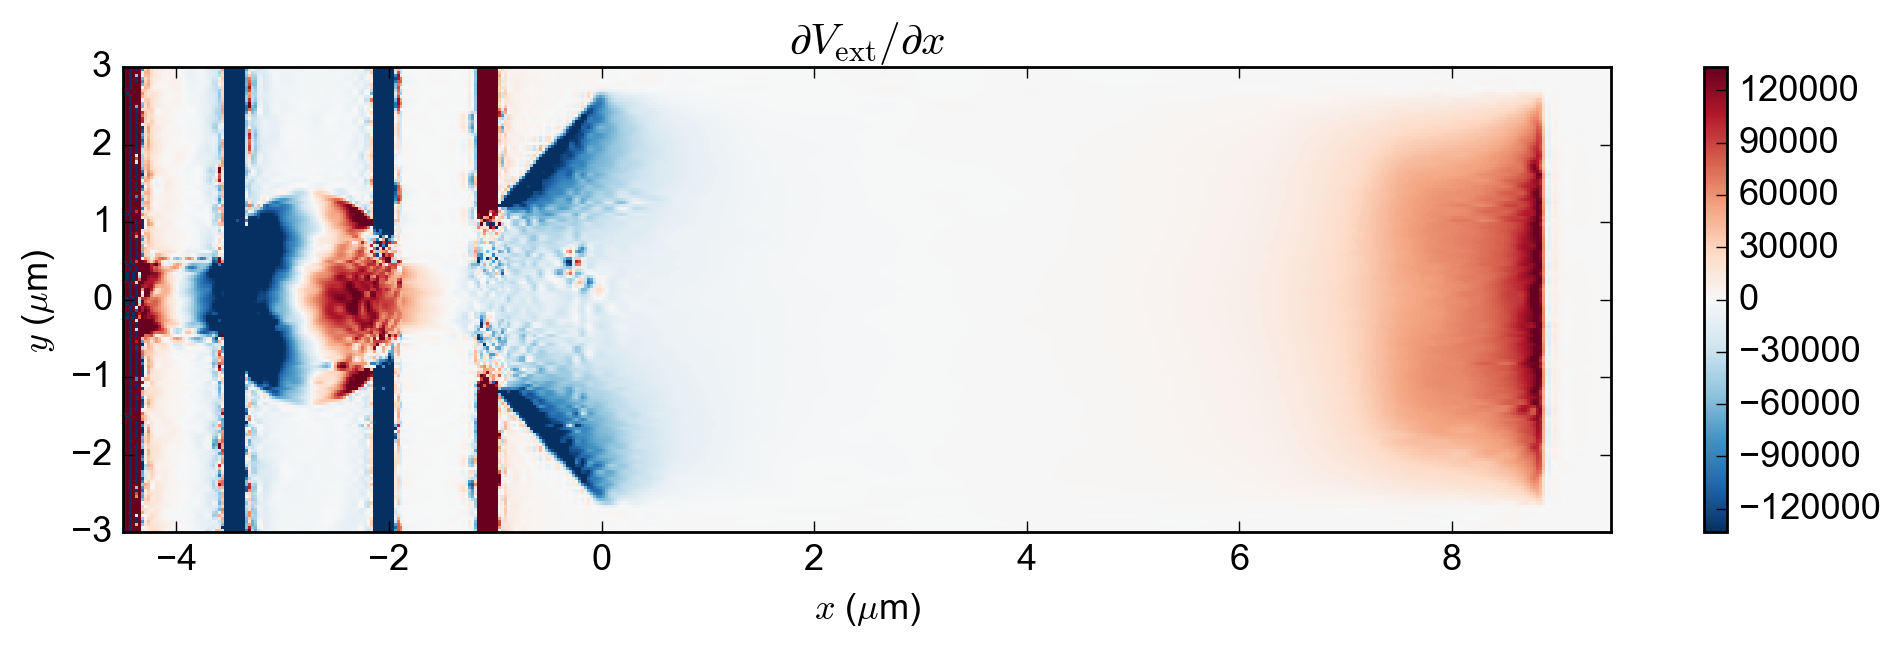

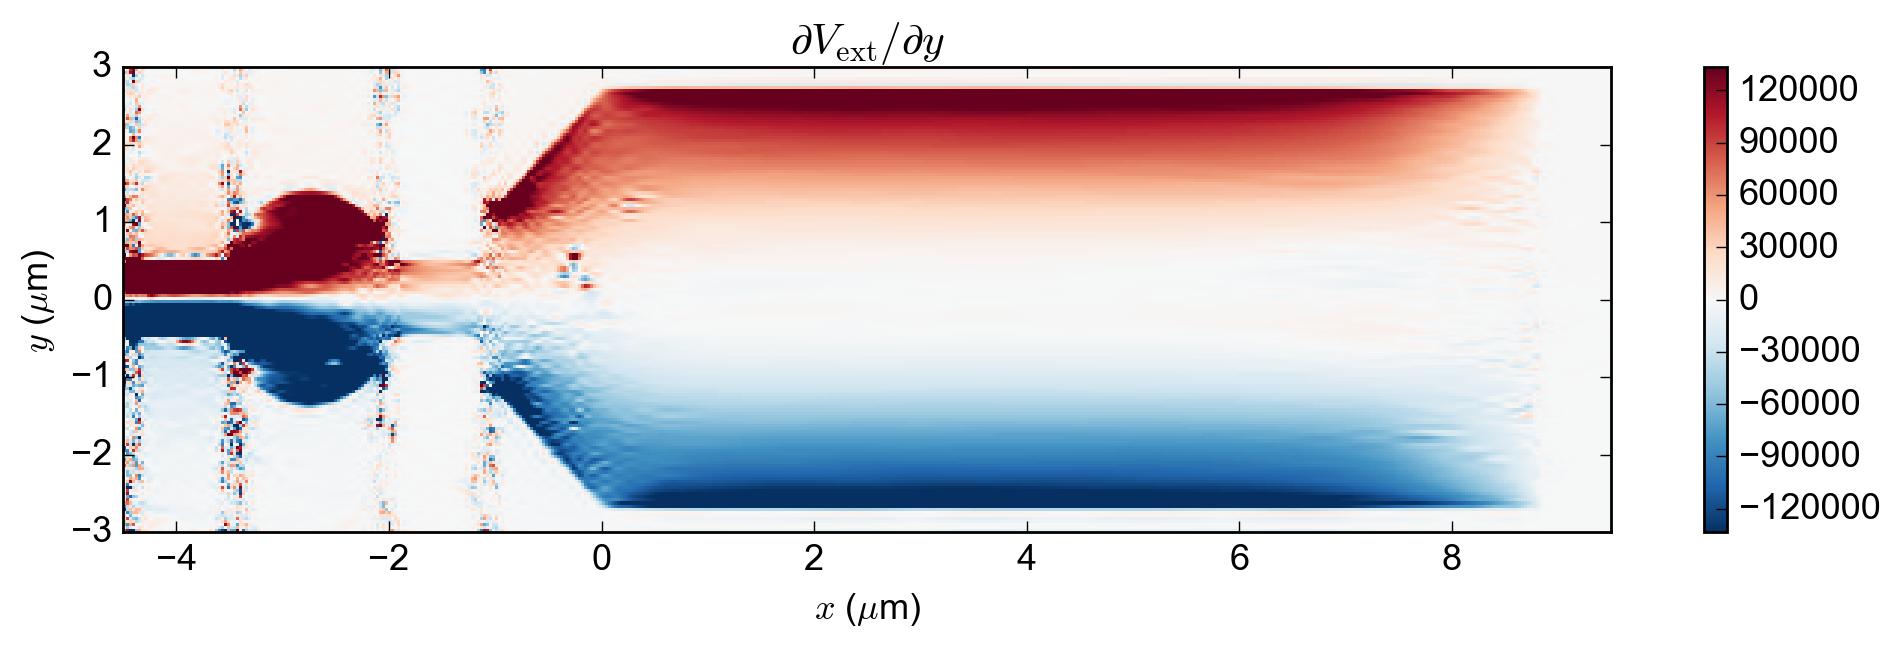

In [8]:
xtest = xeval*1E-6
ytest = yeval*1E-6
Xtest, Ytest = np.meshgrid(xtest, ytest)

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, Vext_meshgrid(Xtest, Ytest), vmax=0.00, vmin=-0.36, cmap=plt.cm.Spectral_r)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title("Interpolated electrostatic potential, Vext_meshgrid")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

if 1:
    plt.figure(figsize=(12.,3.))
    plt.pcolormesh(Xtest*1E6, Ytest*1E6, np.abs(Vext_meshgrid(Xtest, Ytest)- (-combined_potential)), 
                   cmap=plt.cm.Spectral_r)
    plt.colorbar()
    plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
    plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
    plt.title(r"Difference between combined_potential and Vext_meshgrid")
    plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, gradx_Vext(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-1E5*Vres/0.15, vmax=1E5*Vres/0.15)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial V_\mathrm{ext}/\partial x$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, grady_Vext(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-1E5*Vres/0.15, vmax=1E5*Vres/0.15)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial V_\mathrm{ext}/\partial y$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")


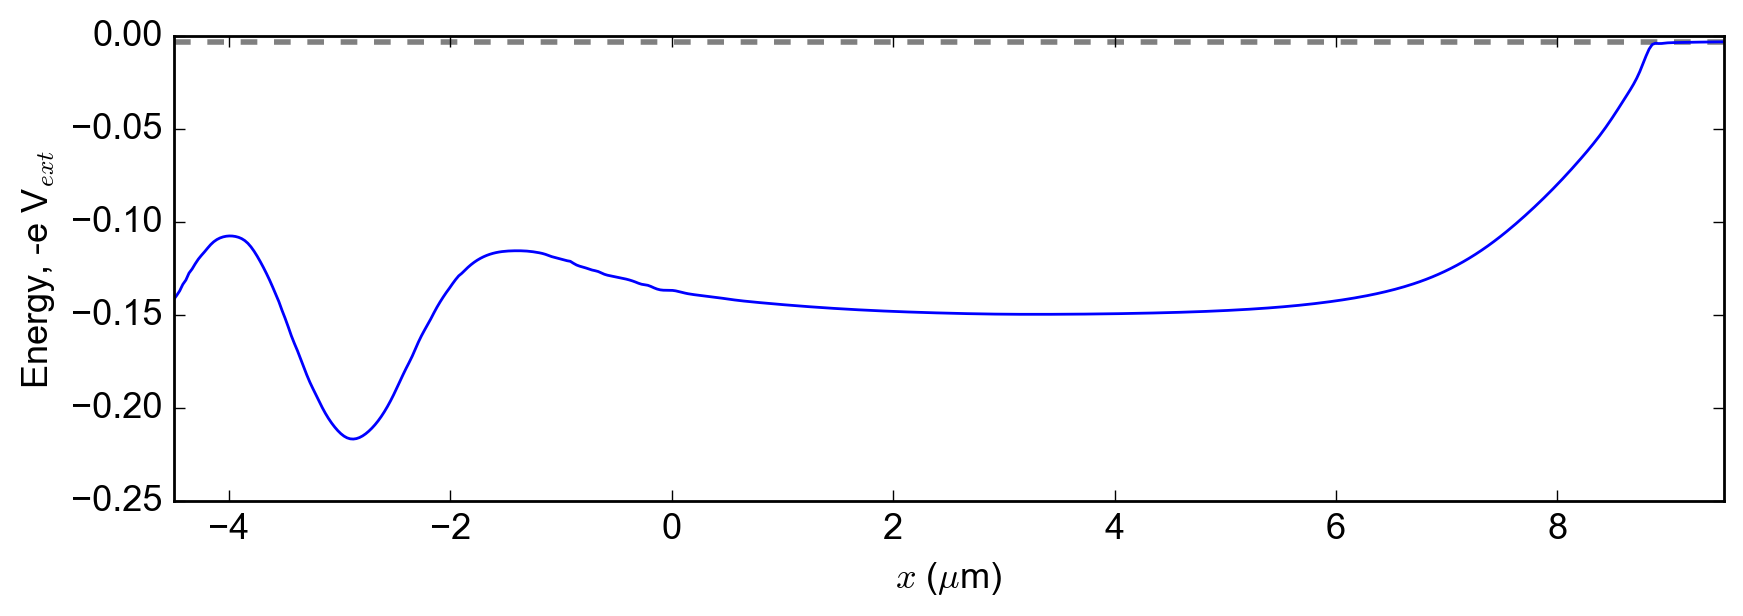

In [9]:
plt.figure(figsize=(10.,3.))
plt.plot(xeval, Vext_meshgrid(xeval*1E-6, 0E-6))
plt.xlim(np.min(xeval), np.max(xeval))
plt.hlines(Vext_meshgrid(xeval*1E-6, 0E-6)[-1], np.min(xeval), np.max(xeval), linestyles='--', color='gray', lw=2.0)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("Energy, -e V$_{ext}$")

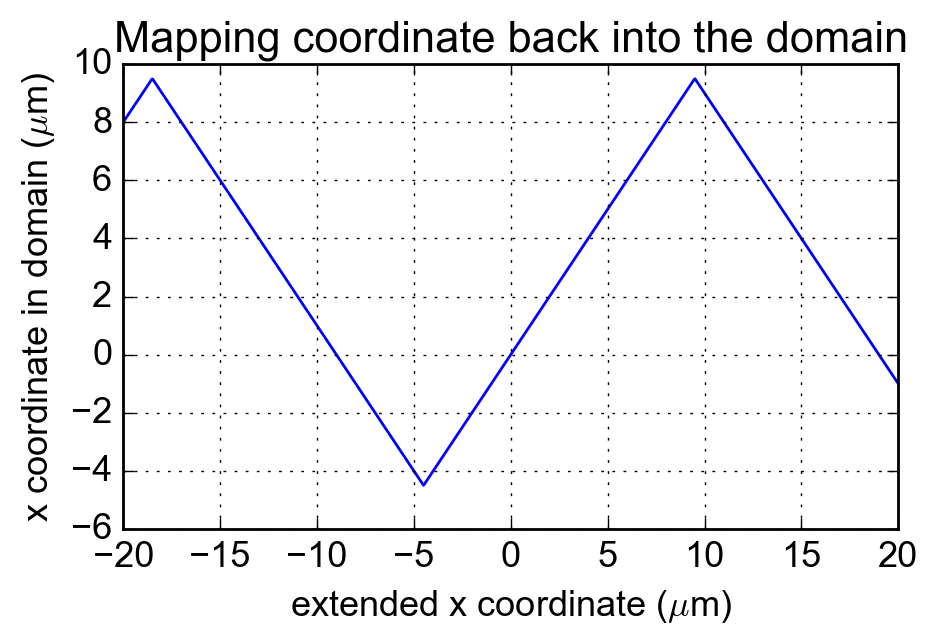

In [10]:
xs = np.linspace(-20, 20, 1E3)
L = xeval[-1] - xeval[0]
left_boundary = xeval[0]
right_boundary = xeval[-1]
f = lambda xi: np.abs(L - (xi - right_boundary) % (2 * L)) + left_boundary

plt.figure(figsize=(5.,3.))
plt.plot(xs, f(xs))
plt.grid()
plt.xlabel("extended x coordinate ($\mu$m)")
plt.ylabel("x coordinate in domain ($\mu$m)")
plt.title("Mapping coordinate back into the domain")

In [11]:
def map_into_domain(xi, yi):
    right_boundary = xeval[-1]*1E-6
    top_boundary = yeval[-1]*1E-6
    bottom_boundary = yeval[0]*1E-6
    left_boundary = xeval[0]*1E-6
    
    L = right_boundary - left_boundary
    W = top_boundary - bottom_boundary
    
    xi = np.abs(L - (xi - right_boundary) % (2 * L)) + left_boundary
    yi[yi>top_boundary] = top_boundary
    yi[yi<bottom_boundary] = bottom_boundary
    
    return xi, yi

def Vext(xi, yi):
    """
    When supplying two arrays of size n to Vext_meshgrid, it returns an array
    of size nxn, according to the meshgrid it has evaluated. We're only interested
    in the sum of the diagonal elements, so we take the trace and this represents 
    the sum of the static energy of the n particles in the potential.
    """
    xi_mapped, yi_mapped = map_into_domain(xi, yi)
    #return c['e'] * np.trace(Vext_meshgrid(xi_mapped, yi_mapped))
    return c['e'] * np.sum(Vext_meshgrid(xi_mapped, yi_mapped))

In [12]:
Vext(np.array([1.0E-6, 1.5E-6, 2.0E-6]), np.array([-3.5E-6, 0, 3.5E-6]))/c['e']

-0.15488140141546861

In [13]:
%timeit Vext(np.array([-2.7E-6, -2.7E-6, -2.7E-6]), np.array([-0.5E-6, 0, 0.5E-6]))

The slowest run took 4.21 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 24.9 µs per loop


In [14]:
def Velectrons(ri, eps=1E-15):
    """
    Returns the repulsion potential between two electrons separated by a distance sqrt(|xi-xj|**2 + |yi-yj|**2)
    Note the factor 1/2. in front of the potential energy to avoid overcounting.
    """
    xi_mapped, yi_mapped = map_into_domain(ri[::2], ri[1::2])
    
    Xi, Yi = np.meshgrid(xi_mapped, yi_mapped)
    Xj, Yj = Xi.T, Yi.T
    
    Rij = np.sqrt((Xi-Xj)**2 + (Yi-Yj)**2)
    np.fill_diagonal(Rij, eps)
    
    return + 1/2. * c['e']**2/(4*np.pi*c['eps0']) * 1/Rij

def Vtotal(r):
    """
    Returns the total energy of N electrons
    r is a 0D array with coordinates of the electrons, in the form 
    r = np.array([x0, y0, x1, y1, x2, y2, ... , xN, yN])
    The x-coordinates are thus given by the even elements of r: r[::2], 
    whereas the y-coordinates are the odd ones: r[1::2]
    """
    Vtot = Vext(r[::2], r[1::2])
    interaction_matrix = Velectrons(r)
    np.fill_diagonal(interaction_matrix, 0)
    Vtot += np.sum(interaction_matrix)
    return Vtot/c['e']

def r2xy(r):
    x = r[::2]
    y = r[1::2]
    return x, y

def xy2r(x, y):
    if len(x) == len(y):
        r = np.zeros(2*len(x))
        r[::2] = x
        r[1::2] = y
        return r
    else:
        raise ValueError("x and y must have the same length!")
        return None

Here are the parameters of the simulation. I arrange the electrons in a circle of radius `initial_radius`. The number of electrons can be tweaked by changing `N_electrons`

In [15]:
N_electrons = 100

if 1: 
    # Rectangle
    N_cols = 10
    N_rows = 10
    if N_cols*N_rows != N_electrons:
        raise ValueError("N_cols and N_rows are not compatible with N_electrons")
    else:
        separation = 200E-9
        x0 = 4E-6
        xs = np.linspace(x0, x0+N_cols*separation, N_cols)
        xinit = np.tile(np.array(xs), N_rows)
        ys = np.linspace(-(N_rows-1)/2.*separation, +(N_rows-1)/2.*separation, N_rows)
        yinit = np.repeat(ys, N_cols)
if 0: 
    # Semi-circle
    initial_radius = 2.0E-6
    xinit = xeval[-1]*1E-6 + initial_radius*np.cos(2*np.pi * np.arange(0, N_electrons)/(2*N_electrons) + np.pi/2.)
    yinit = initial_radius*np.sin(2*np.pi * np.arange(0, N_electrons)/(2*N_electrons) + np.pi/2.)
if 0: 
    # Single line parallel to y
    x0 = 1E-6
    initial_span = 3E-6   
    xinit = x0 * np.ones(N_electrons)
    yinit = np.linspace(-initial_span/2., initial_span/2., N_electrons)

electron_initial_positions = xy2r(xinit, yinit)

We can now evaluate the total potential at the initial positions of the electrons. This gives us an idea of the number we see when we start the minimization procedure. 

In [16]:
Vtotal(electron_initial_positions)

-5.7333901474505913

This number will always go down when we start the minimization (per definition). Let's find out how fast the function call is for the total energy:

In [17]:
%timeit Vtotal(electron_initial_positions)

The slowest run took 4.24 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 258 µs per loop


To speed up the convergence we also need to supply the derivative. The derivative consists of two parts, namely the derivative of the interaction term, and the derivative of the interpolated DC potential

In [18]:
def gradient_Velectrons(xi, yi, eps=1E-15):
    #xi, yi = map_into_domain(ri[::2], ri[1::2])
    #xi, yi = ri[::2], ri[1::2]
    
    Xi, Yi = np.meshgrid(xi, yi)
    Xj, Yj = Xi.T, Yi.T
    
    Rij = np.sqrt((Xi-Xj)**2 + (Yi-Yj)**2)
    np.fill_diagonal(Rij, eps)
    
    gradx_matrix = np.zeros(np.shape(Rij))
    grady_matrix = np.zeros(np.shape(Rij))
    gradient = np.zeros(2*len(xi))
    
    gradx_matrix = -1 * c['e']**2/(4*np.pi*c['eps0']) * (Xi-Xj)/Rij**3
    np.fill_diagonal(gradx_matrix, 0)
    
    grady_matrix = +1 * c['e']**2/(4*np.pi*c['eps0']) * (Yi-Yj)/Rij**3
    np.fill_diagonal(grady_matrix, 0)
    
    gradient[::2] = np.sum(gradx_matrix, axis=0)
    gradient[1::2] = np.sum(grady_matrix, axis=0)
    
    return gradient

def total_gradient(ri):
    xi_mapped, yi_mapped = map_into_domain(ri[::2], ri[1::2])
    
    dUdr = np.zeros(len(ri))
    dUdr[::2] = gradx_Vext(xi_mapped, yi_mapped)
    dUdr[1::2] = grady_Vext(xi_mapped, yi_mapped)
    dUdr += gradient_Velectrons(xi_mapped, yi_mapped)/c['e']
    return dUdr

In [19]:
np.sum(total_gradient(electron_initial_positions))

327266.77690337086

Here is the actual minimization. First we set the matplotlib to Agg to suppress any plots that may come up. For callback we can choose `monitor_convergence` for simply printing the total energy every `N` iterations. We can also choose `save_pictures` to create a movie afterwards. The latter also prints the function value every `N` iterations. 

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


0	Uopt: -7.90264013 eV	Norm of gradient: 1.42e+05 eV/m
10	Uopt: -9.90406776 eV	Norm of gradient: 3.03e+05 eV/m
20	Uopt: -10.25553897 eV	Norm of gradient: 2.87e+04 eV/m
30	Uopt: -10.31329332 eV	Norm of gradient: 2.54e+04 eV/m
40	Uopt: -10.43577302 eV	Norm of gradient: 1.94e+04 eV/m
50	Uopt: -10.51354297 eV	Norm of gradient: 1.46e+05 eV/m
60	Uopt: -10.55493632 eV	Norm of gradient: 4.73e+04 eV/m
70	Uopt: -10.55788323 eV	Norm of gradient: 8.87e+03 eV/m
80	Uopt: -10.55850146 eV	Norm of gradient: 1.28e+04 eV/m
90	Uopt: -10.55890574 eV	Norm of gradient: 1.48e+04 eV/m
100	Uopt: -10.55914699 eV	Norm of gradient: 6.05e+03 eV/m
110	Uopt: -10.55926716 eV	Norm of gradient: 4.70e+03 eV/m
120	Uopt: -10.55944152 eV	Norm of gradient: 3.34e+03 eV/m
130	Uopt: -10.55952173 eV	Norm of gradient: 5.47e+03 eV/m
140	Uopt: -10.55956003 eV	Norm of gradient: 4.00e+03 eV/m
150	Uopt: -10.55959192 eV	Norm of gradient: 2.53e+03 eV/m
160	Uopt: -10.55964086 eV	Norm of gradient: 2.58e+03 eV/m
170	Uopt: -10.55969962 eV	N

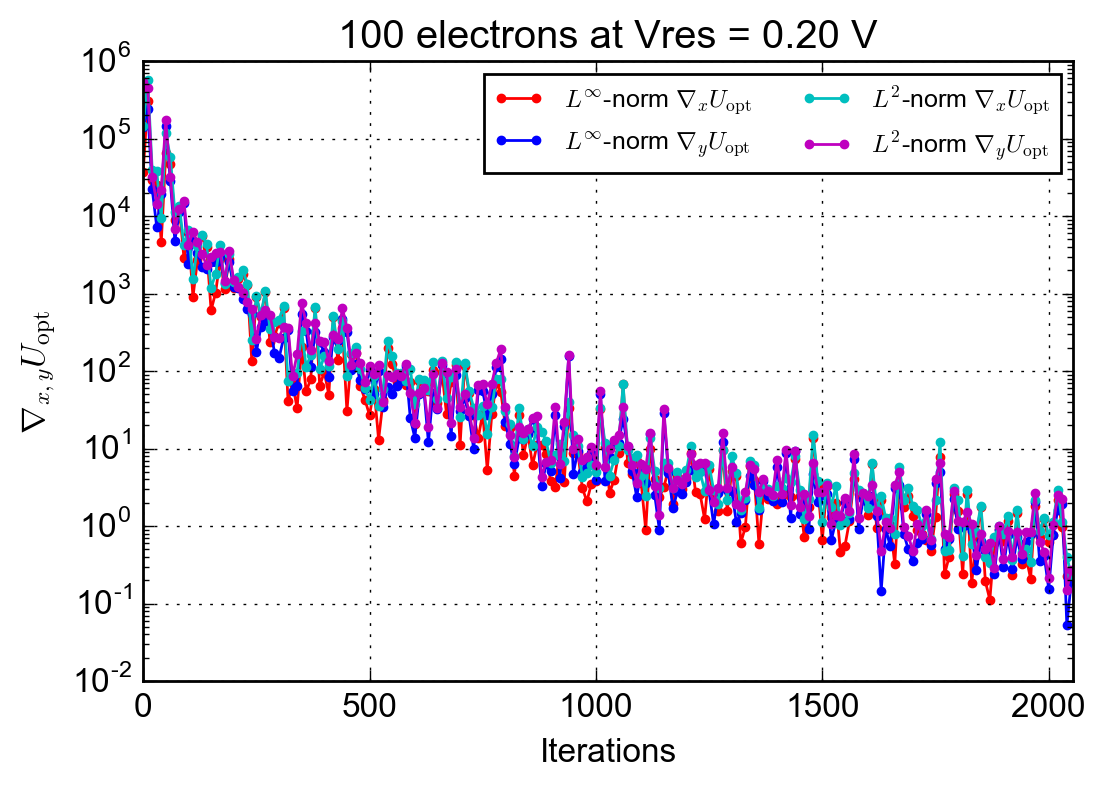

In [20]:
import matplotlib
from numpy import Inf
matplotlib.use('Agg')

epsilon = 1e-12
use_gradient = True

from TrapAnalysis.artificial_anneal import ConvergenceMonitor
ConvMon = ConvergenceMonitor(Uopt=Vtotal, grad_Uopt=total_gradient, N=10, Uext=Vext_meshgrid, 
                             xext=xeval*1E-6, yext=yeval*1E-6, verbose=True, eps=epsilon, 
                             save_path=r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Movie")

if use_gradient: 
    jac=total_gradient
else:
    jac = None

res = minimize(Vtotal, electron_initial_positions, method='CG', 
               jac=jac, 
               options={'disp': True, 'gtol' : 1E-1}, 
               callback=ConvMon.save_pictures)

x, y = r2xy(res['x'])
final_func_val = res['fun']
n_iterations = res['nit']
    
%matplotlib inline

if len(np.shape(ConvMon.jac))>1:
    figgy = plt.figure(figsize=(6,4))
    common.configure_axes(12)
    # LInf-norm
    plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,::2]), axis=1), 
             '.-r', label=r'$L^\infty$-norm $\nabla_x U_\mathrm{opt}$')
    plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,1::2]), axis=1), 
             '.-b', label=r'$L^\infty$-norm $\nabla_y U_\mathrm{opt}$')
    # L2-norm
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,::2])**2.0, axis=1)**(1/2.), 
             '.-c', label=r'$L^2$-norm $\nabla_x U_\mathrm{opt}$')
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,1::2])**2.0, axis=1)**(1/2.), 
             '.-m', label=r'$L^2$-norm $\nabla_y U_\mathrm{opt}$')

    plt.title("%d electrons at Vres = %.2f V"%(N_electrons, Vres))
        
    plt.xlabel("Iterations")
    plt.ylabel(r"$\nabla_{x,y} U_\mathrm{opt}$")
    plt.yscale('log')
    plt.xlim(0, res['nit'])
    plt.grid()
    plt.legend(loc=0, ncol=2, prop = {'size' : 9})

In [22]:
ConvMon.create_movie(fps=10)

In [ ]:
%matplotlib inline

Xinit, Yinit = map_into_domain(xinit, yinit)
X, Y = map_into_domain(x, y)
Xeval, Yeval = np.meshgrid(xeval, yeval)

figgy = plt.figure(figsize=(12,3))
common.configure_axes(12)
plt.pcolormesh(xeval, yeval, Vext_meshgrid(Xeval*1E-6, Yeval*1E-6), cmap=plt.cm.Spectral_r, vmax=0.0)
#plt.plot(x*1E6, y*1E6, 'o', color='deepskyblue')
plt.plot(X*1E6, Y*1E6, 'o', color='deepskyblue')
#plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
#plt.plot(Xinit*1E6, Yinit*1E6, 'o', color='palegreen', alpha=0.5)
# for k, dummy in enumerate(X):
#     plt.text(X[k]*1E6, Y[k]*1E6 + 0.1, str(k+1), fontdict={'color' : 'white', 'size' : 10}, va='bottom', ha='center')

plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
#plt.axes().set_aspect('equal', 'datalim')
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

if save: 
    common.save_figure(figgy, save_path=save_path)

In [ ]:
plt.figure(figsize=(12.,12.))

for n in range(12):
    plt.subplot(4,3,n+1)
    plt.title("Electron #%d"%(n+1))
    plt.plot(ConvMon.func_calls, ConvMon.approx_fprime[:,2*n], 'r', 
             alpha=0.2, lw=4.0, label=r'$\nabla_x$ appr')
    plt.plot(ConvMon.func_calls, ConvMon.gradient_array[:,2*n], 'k', 
             label=r'$\nabla_x$ analytic')
    plt.plot(ConvMon.func_calls, ConvMon.approx_fprime[:,2*n+1], 'b', 
             alpha=0.2, lw=4.0, label=r'$\nabla_y$ appr')
    plt.plot(ConvMon.func_calls, ConvMon.gradient_array[:,2*n+1], 'k', 
             label=r'$\nabla_y$ analytic')
    #plt.plot(grady_Vext(res['x'][::2], res['x'][1::2])/gc['e'])
    if not n%3:
        plt.ylabel(r"$\nabla U_\mathrm{opt}$")
    if n>=9:
        plt.xlabel('Iterations')
    plt.xlim(0, ConvMon.func_calls[-1])
    
    plt.legend(loc=0, prop={'size':9})

In [ ]:
%matplotlib inline

#Xinit, Yinit = map_into_domain(xinit, yinit)
X, Y = map_into_domain(x, y)
Xeval, Yeval = np.meshgrid(xeval, yeval)

figgy = plt.figure(figsize=(7,3))
common.configure_axes(12)
plt.pcolormesh(xeval, yeval, Vext_meshgrid(Xeval*1E-6, Yeval*1E-6), cmap=plt.cm.Spectral_r, vmax=0.0)
plt.plot(x*1E6, y*1E6, 'o', color='deepskyblue')
#plt.plot(X*1E6, Y*1E6, 'o', color='deepskyblue')
plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
#plt.plot(Xinit*1E6, Yinit*1E6, 'o', color='palegreen', alpha=0.5)
for k, dummy in enumerate(X):
    plt.text(x[k]*1E6, y[k]*1E6 + 0.1, str(k+1), fontdict={'color' : 'black', 'size' : 10}, va='bottom', ha='center')

#plt.xlim(np.min(xeval), np.max(xeval))
#plt.ylim(np.min(yeval), np.max(yeval))
#plt.axes().set_aspect('equal', 'datalim')
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

if save: 
    common.save_figure(figgy, save_path=save_path)

In [ ]:
from multiprocessing import Pool
from time import sleep
from random import random

p = Pool(4)

sleep_times = [0, 1, 0, 1]

def awesome_task (ind, sleep_time):
    sleep(sleep_time)
    print(x, sleep_time)
    
p.map(awesome_task, enumerate(sleep_times))